In [10]:
import json
from pathlib import Path
import pandas as pd # used just to "pretty print" tables
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

# Summary of models

We ran several versions of our model. We present 4 versions in more detail: random_v1, random_v2, sports_v1 and sports_v2. Each time we tweak the data set and hyper-parameters to get slightly better results.

All models had training and validation data sampled randomly form the MS Coco train2017 file (which contain ~128k images). The test data was sampled from the MS Coco val2017 file. 

* Models named `random`, just sampled images and associated captions randomly from the data.
* Models named `sports` reduced the scope of data to only pictures including objects within the sports super-category in MS Coco. This reduced the size of the train2017 data from ~128k to ~23k images. Our hypothesis was that it would be easier to train a model with a more specific range of images vs a wide range of images.
* `everything` model was trained on the entire dataset. After splitting into train and val, this gave ~102k training and ~15k validation images.
* `sports_encoder` model used a different encoder. With one fully connected layer at the end rather than 2. This architecture is the more standard way of approaching and encoder/decoder model. We set hyper parameters equal to our best performing model: sports_v2. We are including results, but it is not posssible to recreate them using our code without manually changing some lines in the model.py file. `sports_encoder` was actually the best performing model. 

The table includes some additional columns which should be explained:

* `captions_name`. This sets the name of the vocab and captions json files which are saved for each model. For example, `random_v1` has its captions files saved as `Datasets/coco/annotations/random_v1_train.json`, `Datasets/coco/annotations/random_v1_val.json`, and `Datasets/coco/annotations/random_v1_test.json`. The vocab file is saved as `vocabulary/random_v1word2idx.json`.
* `checkpoint folder`. These is the folder where model checkpoints and other meta data are saved. So `random_v1` model has checkpoints saved in `model/model_v1`. 
* Finally we show the notebook file name where the training was done to ease navigation through our folder.


| Model      | LSTM layers | embedding size | batch_size | freq_threshold | train_size.   |captions_name | checkpoint folder| training_notebook |
| -----------|:--------:   | :------------: | :--------: | :-----------:  | :------------:|------------- | ---------------- | ----------------- |
| random_v1  | 1           | 512            | 32         | 5              | 10k           | random_v1    | model_v1         | train_random_v1   |
| random_v2  | 3           | 1024           | 128        | 5              | 10k           | random_v1    | model_v1         | train_random_v2   |
| sports_v1  | 3           | 1024           | 128        | 5              | 10k           | sports_v1    | model_sports_v1  | train_sports      |
| sports_v2  | 3           | 512            | 128        | 4              | 15k           | sports_v2    | model_sports_v3  | train_sports2     |
| **Other Models** |       |                |            |                |               |              |                  |                   |
| sports_v4  | 3           | 512            | 64         | 5              | 15k           | sports_v4    | model_sports_v4  | train_sports2     |
| sports_v5  | 3           | 1024           | 64         | 5              | 20k           | sports_v5    | model_sports_v5  | train_sports      | 
| everything | 3           | 512            | 64         | 5              | 102k          | everything   | model_everything | train_sports2     |
| sports_encoder | 3       | 512            | 128        | 4              | 15k     | sports_encoder | model_sports_encoder | z_train_sports_enc|
| random_v3  | 3           | 1024           | 128        | 5              | 20k           | random_v3    | model_v3         | train_random_v3.  |




Create some data frames with training information from our models

In [24]:
# with open('../model/summary_results/result_summary.json', 'r') as f:
#     results = json.load(f)

max_idx = 45
train_loss_df = pd.DataFrame(index = range(max_idx))
val_loss_df = pd.DataFrame(index = range(max_idx))
bleu_df = pd.DataFrame(index = results.keys(), columns=['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'])
summary_df = pd.DataFrame(index = results.keys(), 
                          columns=['embed_size' , 'hidden_size', 'LSTM_layers', 'vocab_size',
                                   'batch_size', 'train_loss_10_epochs', 'val_loss_10_epochs', 'BLEU-4'])

for key, val in results.items():
    train_loss_df[key] = val['train_loss'] + [np.nan] * (max_idx - len(val['train_loss']))
    val_loss_df[key] = val['val_loss'] + [np.nan] * (max_idx - len(val['val_loss']))
    bleu_df.loc[key,
                ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']] = [b * 100 for b in val['bleu_score']] 
    for field in ['embed_size' , 'hidden_size', 'LSTM_layers', 'vocab_size', 'batch_size']:
        try: 
            summary_df.at[key, field] = val[field]
        except:
            pass
    for field in [('train_loss', 'train_loss_10_epochs'), ('val_loss', 'val_loss_10_epochs')]:
        try: 
            summary_df.at[key, field[1]] = round(val[field[0]][9],3)
        except:
            pass
    summary_df.at[key, 'BLEU-4'] = val['bleu_score'][3]

row_order = ['random_v1', 'random_v2', 'sports_v1', 'sports_v2', 
             'sports_v4', 'sports_v5', 'everything', 'random_v3', 
             'sports_encoder']
main_rows = ['random_v1', 'random_v2', 'sports_v1', 'sports_v2']


In [22]:
['embed_size' , 'hidden_size', 'LSTM_layers', 'vocab_size', 'batch_size']
results['sports_encoder']['embed_size'] = 512
results['sports_encoder']['hidden_size'] = 512
results['sports_encoder']['LSTM_layers'] = 3
results['sports_encoder']['vocab_size'] = 2921
results['sports_encoder']['batch_size'] = 128


In [21]:
summary_df.loc[row_order, :]

embed_size hidden_size LSTM_layers vocab_size batch_size  \
random_v1             512         512           1       3389         32   
random_v2            1024         512           3       3389        128   
sports_v1            1024         512           3       2110        128   
sports_v2             512         512           3       2921        128   
sports_v4             512         512           3      10192         64   
sports_v5            1024         512           3       2988         64   
everything            512         512           3      10192         64   
random_v3            1024         512           3       4699        128   
sports_encoder        NaN         NaN         NaN        NaN        NaN   

               train_loss_10_epochs val_loss_10_epochs BLEU-4  
random_v1                     3.088              3.053  0.161  
random_v2                     2.915              2.898  0.177  
sports_v1                      2.34              2.306  0.242  
sports_v2                     2.372              2.347  0.248  
sports_v4                     2.472              2.436   0.23  
sports_v5                     2.398              2.455  0.212  
everything                    3.072              3.036  0.165  
random_v3                     2.928              2.938  0.174  
sports_encoder                2.352              2.316  0.261

### Results: BLEU scores

As we move from `random_v1` to `sports_v2`, BLEU scores get progressively better with `sports_v2` scoring 24.8 on BLEU-4.

The `sports_encoder` model does the best on BLEU-4 metric. This model has the same hyper parameters ous `sports_v2` - our best performing model otherwise. With `sports_encoder`, we only used one fully connected layer at the end of the encoder. All other models were run with 2 fully connected layers. In future work we will modify our encoder to use only one fully connected layer: improvements in accuracy are uncertain (neither of `sports_v1` or `sports_encoder` dominates the other across all metrics) but removing a fully connected layer simplifies the architecture and speeds up training which are desirable properties.


In [13]:
bleu_df.loc[row_order, :]

BLEU-1 BLEU-2 BLEU-3 BLEU-4
random_v1        61.4   40.9   25.6   16.1
random_v2        61.4   42.5   27.6   17.7
sports_v1        69.5   50.7   35.5   24.2
sports_v2        69.9   51.7   35.8   24.8
sports_v4        66.5   48.3   33.5   23.0
sports_v5        64.4   46.2   30.9   21.2
everything       60.4   40.6   26.0   16.5
random_v3        60.8   41.7   27.2   17.4
sports_encoder   68.1   50.5   36.1   26.1

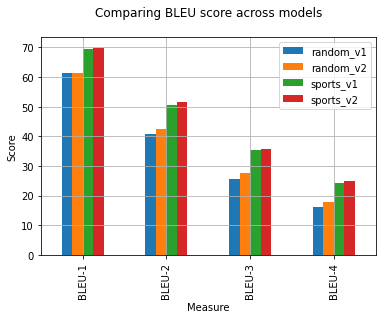

In [14]:
bleu_df.loc[main_rows,:].transpose().plot(kind="bar", grid=True,
                                          title="Comparing BLEU score across models\n",
                                          xlabel="Measure", ylabel="Score");

### Compare training an validation loss aver time

The charts below show training and validation loss per epoch for our four principal models.

`random_v1` was the only model we trained with only one LSTM layer. More work is required to verify that one-layer is the cause, but it is notable that random_v1 made minimal improvements after the 2nd epoch.

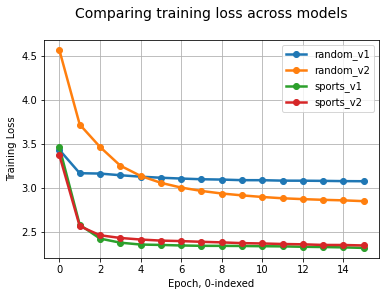

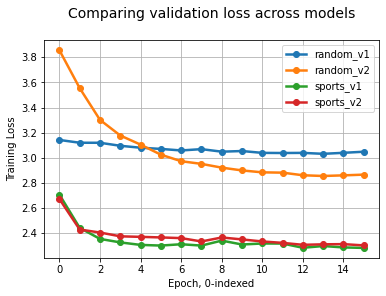

In [15]:
fig = train_loss_df.loc[:15, main_rows].plot(grid=True, lw=2.5, marker="o",
                                             title="Comparing training loss across models\n",
                                             xlabel="Epoch, 0-indexed", ylabel="Training Loss",
                                             )
fig.axes.title.set_size(14)
plt.show()
fig = val_loss_df.loc[:15, main_rows].plot(grid=True, lw=2.5, marker="o",
                                           title="Comparing validation loss across models\n",
                                           xlabel="Epoch, 0-indexed", ylabel="Training Loss")
fig.axes.title.set_size(14)
plt.show()

### Choice of vocabulary

For most models, we generated the vocabulary using the captions in the training data, with a threshold of 5 for word inclusion. The original paper used 5 as a threshold.

We had two theories to test:
1. Given that a lot of our training was on much smaller data sets than the full 128k MS Coco training set, would a threshold of 5 be too high to for inclusion of important words? Our best performing model - `sports_v2` used a threshold of 4. `sports_v2` only differed to `sports_v4` in batch size (128 vs 64) and frequency threshold (4 vs 5). It seems likely that 4 was a good choice training with our smaller datasets of ~15k training images. 
2. Another theory was that choosing a larger vocab may help a model to generalise. We set the vocab for `sports_v5` using the ENTIRE train2017 captions. In the event, it seems that `sports_v5` over fit. The validation losses became very volatile as can be seen below, and the BLEU scores were the worst of the sport dataset models we trained.

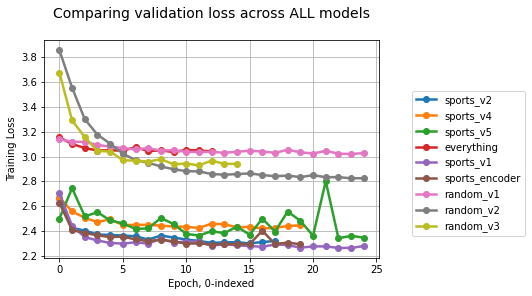

In [16]:
fig = val_loss_df.iloc[:25,:].plot(grid=True, lw=2.5, marker="o",
                                   title="Comparing validation loss across ALL models\n",
                                   xlabel="Epoch, 0-indexed", ylabel="Training Loss")
plt.legend(loc=(1.1,0.1))
fig.axes.title.set_size(14)
plt.show()

### Choice of embedding size

512 is a popular size of word embedding in NLP tasks. We also experimented with larger embeddings of 1024. A larger embedding should allow the model to build a richer representation of the vocabulary. But given that our vocab sizes were mostly 2k and at most 10k, maybe an embedding size of 1024 represented too many degrees of freedom. Again it is hard to definitely tell the difference, but from looking at the differences in results and hyper parameters for `sports_v1`, `sports_v2` and `sports_v4` it seems hard to conclude which embedding size is different. 

We should either do more experiments, or use 512 for simplicity and improved speed of training.

In [9]:
for key, val in results.items():
    print(key)
    print(val['model_summary'])
    print()

sports_v2
only images containing objects from sports super-category.
train/val/test size 15k/2k/1k
frequency threshold: 4
vocab size: 2921
batch size: 128
embed size: 512
hidden size: 512
LSTM layers: 3


sports_v4
only images containing objects from sports super-category.
train/val/test size 15k/2k/1k
frequency threshold: 5
vocab size: 10192
batch size: 64
embed size: 512
hidden size: 512
LSTM layers: 3


sports_v5
only images containing objects from sports super-category.
train/val/test size 20k/3k/1k
frequency threshold: 5
vocab size: 2988
batch size: 64
embed size: 1024
hidden size: 512
LSTM layers: 3


everything
images sampled from entire train2017 data set
train/val/test size 102k/15k/5k
frequency threshold: 5
vocab size: 10192
batch size: 64
embed size: 512
hidden size: 512
LSTM layers: 3


sports_v1
only images containing objects from sports super-category.
train/val/test size 10k/2k/1k
frequency threshold: 5
vocab size: 2110
batch size: 128
embed size: 1024
hidden size: 512
L